In [55]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clustering/src')

!pip install pymysql
import prepare

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, X_val, y_train, y_test, y_val = prepare.wrangle_zillow(test_size=.10, k=3, thresh=.4)
X_train['county'] = X_train.fips.map({6111:"Ventura", 6037:"Los Angeles", 6059:"Orange"})

These columns were dropped.
                          missing count  missing %
airconditioningtypeid             49095   0.680722
architecturalstyletypeid          71916   0.997144
basementsqft                      72072   0.999307
buildingclasstypeid               72122   1.000000
decktypeid                        71508   0.991487
finishedfloor1squarefeet          66101   0.916516
finishedsquarefeet13              72081   0.999432
finishedsquarefeet15              72111   0.999847
finishedsquarefeet50              66101   0.916516
finishedsquarefeet6               71955   0.997684
fireplacecnt                      63861   0.885458
garagecarcnt                      46826   0.649261
garagetotalsqft                   46826   0.649261
hashottuborspa                    70585   0.978689
poolcnt                           56399   0.781994
poolsizesum                       71255   0.987979
pooltypeid10                      71659   0.993580
pooltypeid2                       71048   0.985109
poo



Your target variable is logerror.

1. Is target significantly different for properties in LAC vs OC vs VC?
2. Divide age of house into bins; same question for age bins.
3. What are the top five features for predicting target?
4. Is there a linear relationship between price per square foot and target? (Pearson r)
5.  Compute the mean(logerror) by zipcode and the overall mean(logerror). Run a t-test between the overall mean and the mean for each zip code. What zip codes have an error significantly higher or lower than the expected error?

Answer those questions through a mix of statistical tests and visualizations.


In [10]:
X_train.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,finishedsqft,fips,heatingorsystemtypeid,latitude,longitude,propertylandusetypeid,regionidcity,regionidzip,structuretaxvalue,taxvalue,landtaxvalue,taxamount,censustractandblock,95982.0,95983.0,95984.0,95985.0,95986.0,95987.0,95988.0,95989.0,95991.0,95992.0,95993.0,95994.0,95995.0,95996.0,95997.0,95998.0,95999.0,96000.0,96001.0,96002.0,96003.0,96004.0,96005.0,96006.0,...,97088.0,97089.0,97091.0,97092.0,97094.0,97097.0,97098.0,97099.0,97101.0,97104.0,97106.0,97107.0,97108.0,97109.0,97111.0,97113.0,97116.0,97118.0,97119.0,97298.0,97316.0,97317.0,97318.0,97319.0,97323.0,97324.0,97328.0,97329.0,97330.0,97331.0,97344.0,399675.0,livingarearatio,buildinglandvalueratio,taxrate,age,acres,sqftvalue,age_bins,county
parcelid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14131785,1.5,2.0,5.0,1842.0,6059.0,2.0,33.863307,-118.006433,261.0,10608.0,96181.0,71089.0,455635.0,384546.0,5340.56,6.059111e+13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.286247,0.184865,0.011721,62.0,0.147727,247.358849,1,Orange
14036019,2.0,4.0,5.0,2106.0,6059.0,2.0,33.729043,-117.915630,261.0,8384.0,97008.0,147489.0,226408.0,78919.0,2754.42,6.059099e+13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.292500,1.868866,0.012166,39.0,0.165289,107.506173,0,Orange
14615017,1.5,2.0,5.0,952.0,6059.0,2.0,33.926044,-117.947310,266.0,18874.0,96186.0,83849.0,238495.0,154646.0,2935.96,6.059001e+13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.192467,0.542200,0.012310,37.0,0.157025,250.519958,0,Orange
14446936,2.5,3.0,5.0,1559.0,6059.0,2.0,33.454801,-117.656463,261.0,13693.0,96982.0,126679.0,410000.0,283321.0,4529.14,6.059042e+13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.989841,0.447122,0.011047,40.0,0.036157,262.989096,0,Orange
14301989,2.0,3.0,5.0,1528.0,6059.0,2.0,33.700118,-117.787281,261.0,52650.0,96941.0,113716.0,316787.0,203071.0,3288.86,6.059053e+13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.279546,0.559981,0.010382,44.0,0.125482,207.321335,0,Orange


In [3]:
X_train.age.describe()

count    46438.000000
mean        47.771394
std         22.609488
min          2.000000
25%         31.000000
50%         46.000000
75%         63.000000
max        139.000000
Name: age, dtype: float64

Check it and see, son. Log error is significantly different between LAC and OC and not different between VC and OC. The third is a toss up.

Newer and older homes have a significant difference in logerrors.

TOP 10 features included some zip codes and then longitude. That's new.

(-0.3, 0.3)

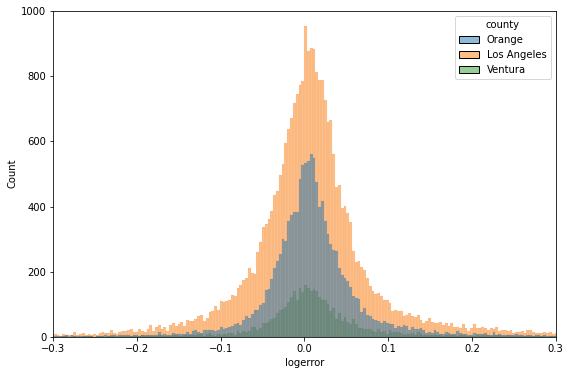

In [44]:
f,ax = plt.subplots(figsize=(9,6))
sns.histplot(data=X_train, x=y_train, hue='county')
plt.xlim(-.3,.3)

In [48]:
lac = y_train[X_train.county=="Los Angeles"]
oc = y_train[X_train.county=="Orange"]
vc = y_train[X_train.county=="Ventura"]
lac_oc = scs.mannwhitneyu(lac, oc)
lac_vc = scs.mannwhitneyu(lac, vc)
vc_oc = scs.mannwhitneyu(vc, oc)

print(lac.mean(), oc.mean(), vc.mean())
print("p-values comparing means of logerrors\n")
print(f"LAC, OC: {lac_oc[1]}")
print(f"LAC, VC: {lac_vc[1]}")
print(f"VC, OC: {vc_oc[1]}")

0.013972762824462458 0.021471485037741923 0.012774236677120151
p-values comparing means of logerrors

LAC, OC: 7.946143627528753e-05
LAC, VC: 0.025014075719400272
VC, OC: 0.322229755239826


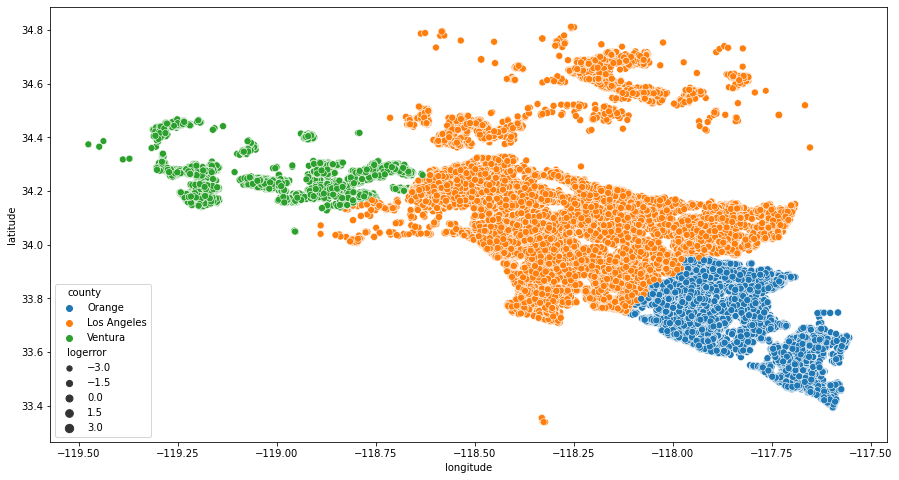

In [57]:
f,ax = plt.subplots(figsize=(15,8))
sns.scatterplot(data=X_train, x='longitude', y='latitude', hue='county', size=y_train)

In [45]:
new = y_train[X_train.age_bins==0] #newer
old = y_train[X_train.age_bins==1]

new_old = scs.mannwhitneyu(new, old)

print("\np-values comparing means of logerrors\n")
print(f"Newer, older: {new_old[1]}")


p-values comparing means of logerrors

Newer, older: 0.0013085489368683488


In [19]:
X_train.drop(columns=['county'], inplace=True)

In [25]:
f_selector = make_pipeline(MinMaxScaler(), SelectKBest(f_regression, k=10))
f_selector.fit(X_train, y_train)
feature_mask = f_selector[1].get_support()
f_feature = X_train.iloc[:,feature_mask].columns.tolist()
f_feature


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


['bathroomcnt',
 'bedroomcnt',
 'finishedsqft',
 'longitude',
 96043.0,
 96218.0,
 96951.0,
 96957.0,
 97037.0,
 'sqftvalue']

In [26]:
scs.pearsonr(X_train.sqftvalue, y_train)

(-0.033076717553742606, 1.0064728474951952e-12)

In [54]:
mean_error = y_train.mean()
zips = set(X_train.regionidzip)

for zip_ in zips:

  subset = y_train[X_train.regionidzip==zip_]
  x1, n1, s1 = subset.mean(), len(subset), subset.std()
  x2, n2, s2 = y_train.mean(), len(subset), y_train.std()
  alpha, degf = .05, n1 + n2 - 2

  print(x1, n1, s1)
  """

  s_p = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2)/degf) #pooled st. dev.
  t = (x1-x2) / (s_p*np.sqrt((1/n1) + (1/n2))) #-2.6
  p = scs.t(degf).cdf(t)*2 #two-tailed; use cdf because t-stat is negative
  
  if p < alpha:
    print("Reject the null for (zip_). The means are different.\n")
  """

0.010549809239867152 165 0.13136748049808722
0.004171418676004048 132 0.16686716171049013
0.018348888425099488 116 0.1873963310219494
0.028270945588291376 73 0.11201156293049906
-0.017138900915893294 86 0.12622518143226763
0.045316865024851 127 0.23566809245769543
0.026646109503292662 30 0.09877304287332471
0.05566512047546163 49 0.2150439448214167
-0.05538183279186144 76 0.11103386932209569
0.01613764670726065 126 0.09508090922388969
0.027660247409960426 130 0.169807068362261
0.0009231594742132279 88 0.05524273710372329
0.02483577344117179 96 0.19306286019294752
0.0109350748795007 128 0.11211867460017408
0.004643807473503259 92 0.09868114710943716
-0.015078877107948526 137 0.06655269492339722
0.005477863665719611 145 0.0968538238494293
-0.007479855367293229 34 0.12232067632718596
0.013320765085541723 51 0.11085483742937735
0.012118689517770192 90 0.10794022308740207
0.020168757611933794 29 0.11369883157123443
0.00398434630742222 9 0.07980177314807148
0.009876183782374877 50 0.07868882